# Data clean







## Estimating Rural Land Rent

We estimate rural land rent based on agricultural land productivity, using the GAEZ v4 dataset. Specifically, we use 2010 value of production data and adjust it to 2022 currency terms using the Consumer Price Index (CPI).

### GAEZ v4

The GAEZ v4 dataset provides agricultural production values measured in **GK\$**, which are international price weights calculated by the FAO for the year 2000.

For crop groups that include a wide variety of crops (e.g., vegetables, stimulants, crops not elsewhere specified), a consistent set of international price weights—compiled by the FAO in year 2000 US dollars—was used to aggregate individual crop values. The total production volume is expressed in **million GK\$**.

Each crop's harvested area is recorded in **thousands of hectares**, and yields are reported either in **tons per hectare** or in **thousands of GK\$ per hectare**, depending on the unit used for total crop production.




{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 4320, 'height': 2160, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}
1


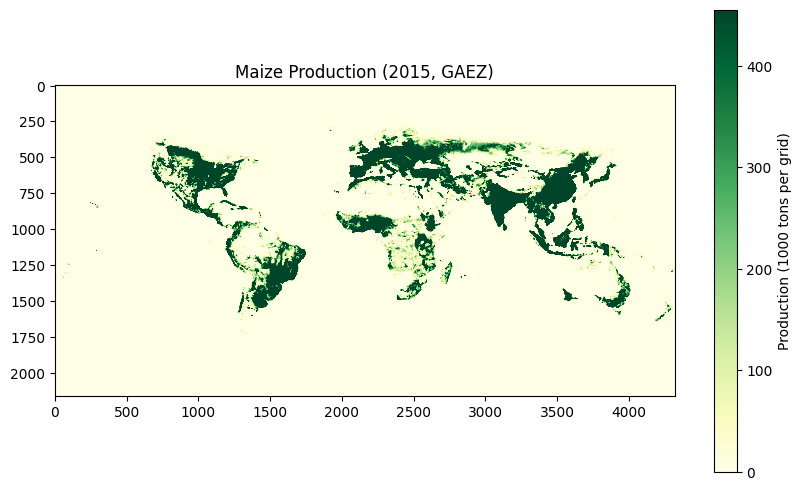

In [76]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

tif_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/Gaze_2010/all_2010_val.tif"
with rasterio.open(tif_path) as src:
    print(src.profile)  # print the metadata of the raster file
    print(src.count)   # number of bands in the raster file
    data = src.read(1)           
    profile = src.profile         
    transform = src.transform    
    crs = src.crs                

data[data < -1e30] = np.nan   

# visualize the data
plt.figure(figsize=(10, 6))
plt.imshow(data, cmap='YlGn', vmin=np.nanpercentile(data, 5), vmax=np.nanpercentile(data, 95))
plt.colorbar(label="Production (1000 tons per grid)")
plt.title("Maize Production (2015, GAEZ)")
plt.show()


In [89]:
import pandas as pd
from rasterio.transform import xy

with rasterio.open(tif_path) as src:
    data = src.read(1)                
    transform = src.transform
    nodata_val = src.nodata

data = np.where(data == nodata_val, np.nan, data)

rows, cols = np.where(~np.isnan(data))
values = data[rows, cols]

lons, lats = xy(transform, rows, cols)

df = pd.DataFrame({
    "lon": lons,
    "lat": lats,
    "value": values
})


df.head()

# df.to_csv("maize_production_2015.csv", index=False)


,lon,lat,value
0,29.041667,70.875,2.402339
1,24.708333,70.625,1.592087
2,26.541667,70.625,0.660682
3,26.625000,70.625,8.401594
4,27.208333,70.625,5.189222


In [ ]:
# approximate the bounding box of China
df_china = df.query("lon >= 73 and lon <= 136 and lat >= 18 and lat <= 54")
df_china = df_china.reset_index(drop=True)
df_china.head()

,lon,lat,value
0,73.041667,53.958333,282.186432
1,73.125000,53.958333,414.087646
2,73.208333,53.958333,436.086975
3,73.291667,53.958333,312.478302
4,73.375000,53.958333,285.594421


In [95]:
q99 = df_china["value"].quantile(0.99)
q_max = df_china["value"].max()

print(f"99th percentile: {q99}")
print(f"Max value: {q_max}")


99th percentile: 18486.00054687496
Max value: 42845.24609375


In [ ]:
iqr = df_china["value"].quantile(0.75) - df_china["value"].quantile(0.25)
upper_fence = df_china["value"].quantile(0.75) + 3 * iqr
df_china = df_china[df_china["value"] < upper_fence]

In [98]:
usd_to_rmb_2000 = 8.28      
# China's CPI ratio from 2000 to 2022
cpi_list = [ 100.7, 99.2, 101.2, 103.9, 101.8, 101.5,\
             104.8, 105.9, 99.3, 103.3, 105.4, 102.6,\
             102.6, 102.0, 101.4, 102.0, 101.6, 102.1,\
             102.9, 102.5, 100.9, 102.0]

cpi_ratio = 1.0
for cpi in cpi_list:
    cpi_ratio *= (cpi / 100)

print(f"2000 to 2022 CPI ratio: {cpi_ratio:.4f}")


df_china["price_ha"] = df_china["value"] * 1000 * usd_to_rmb_2000 * cpi_ratio

df_china["price_m2"] = df_china["price_ha"] / 10000

2000 to 2022 CPI ratio: 1.6285


In [99]:
df_china.head()

,lon,lat,value,price_ha,price_m2
0,73.041667,53.958333,282.186432,3804941.5,380.494141
1,73.125000,53.958333,414.087646,5583469.0,558.346924
2,73.208333,53.958333,436.086975,5880103.0,588.010315
3,73.291667,53.958333,312.478302,4213390.0,421.338989
4,73.375000,53.958333,285.594421,3850893.5,385.089355


In [100]:
df_china_sorted = df_china.sort_values(by="value", ascending=False)
df_china_sorted = df_china_sorted.reset_index(drop=True)
df_china_sorted.head()

,lon,lat,value,price_ha,price_m2
0,116.708333,32.125000,16100.825195,217100064.0,21710.005859
1,116.708333,32.041667,16096.256836,217038464.0,21703.845703
2,118.791667,31.375000,16095.807617,217032416.0,21703.242188
3,119.041667,39.291667,16093.022461,216994848.0,21699.484375
4,114.958333,30.458333,16092.904297,216993264.0,21699.326172


In [101]:
df_china.describe()

,lon,lat,value,price_ha,price_m2
count,154417.000000,154417.000000,154417.000000,1.544170e+05,154417.000000
mean,102.660176,35.632305,2546.926758,3.434221e+07,3434.220703
std,17.839330,11.102006,3266.067627,4.403896e+07,4403.895508
min,73.041667,18.041667,0.017789,2.398572e+02,0.023986
25%,85.208333,25.625000,114.185425,1.539652e+06,153.965164
50%,104.958333,34.125000,1151.020142,1.552011e+07,1552.010742
75%,116.708333,46.458333,3900.510986,5.259365e+07,5259.365234
max,135.958333,53.958333,16100.825195,2.171001e+08,21710.005859


In [105]:
df_china.to_csv("/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/arg_val_2022.csv", index=False)

## Matching Residential Communities with Provincial and Municipal Boundaries (Using 2020 Administrative Map)

A small number of residential community points could not be matched to the administrative boundaries. This is likely due to slight inaccuracies in geolocation coordinates obtained from Gaode or Baidu Maps. However, since the unmatched portion is extremely small, we chose to drop them.

* **Successfully matched data points:** 899,161
* **Unmatched data points:** 135
* **Total data points:** 899,296
* **Match rate:** 99.98%

Given the high match rate, the unmatched data points were excluded from further analysis.

In [63]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

community_csv_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/community_loc_hp.csv"
admin_shp_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_Adm_2020/China2020County.shp"
output_csv_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price.csv"
unmatched_csv_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price_unmatched.csv"

# transform the community data into a geodataframe
df = pd.read_csv(community_csv_path)
gdf_community = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["lng84"], df["lat84"]),
    crs="EPSG:4326"
)

# check if the CRS of the community data is the same as the admin data
gdf_admin = gpd.read_file(admin_shp_path)
if gdf_admin.crs != gdf_community.crs:
    gdf_admin = gdf_admin.to_crs(gdf_community.crs)


In [64]:
# consider the points that are on the boundary of the polygons
gdf_joined_all = gpd.sjoin(gdf_community, gdf_admin, how="left", predicate="intersects")
gdf_joined_first = gdf_joined_all.sort_values(by="index_right").drop_duplicates(subset="id")

In [65]:
pd.set_option('display.max_columns', None)

In [66]:
gdf_joined_all.head(3)

,id,名称,城市,区县,乡镇,建筑年份,类型,地址,lng84,lat84,供热,容积率,面积,总户数,类型.1,供水,得分,月份,环比,价格,geometry,index_right,地名,区划码,县级,县级码,县级类,地级,地级码,地级类,省级,省级码,省级类,曾用名,备注,ENG_NAME,VAR_NAME,code,NAME_3,VAR_NAME3,GID_3,TYPE_3,NAME_2,VAR_NAME2,GID_2,TYPE_2,NAME_1,VAR_NAME1,GID_1,TYPE_1,year
0,1,万科惠斯勒小镇,鞍山,铁东,明达,2015,多层|高层,湖南街202号,123.026172,41.079107,1.0,NaN,NaN,2564,公寓住宅,民用,7.3,12,0.59,8120.0,POINT (123.02617 41.07911),2778.0,铁东区,210302.0,铁东区,210302.0,市辖区,鞍山市,210300.0,地级市,辽宁省,210000.0,省,None,None,Tiedong,Tiě Dōng,210302.0,Tiedong,TiěDōng,210302.0,District?,Anshan,ān Shān,210300.0,Prefecture City?,Liaoning,Liáo?Níng,210000.0,Province,2020.0
1,2,万科金域华府,鞍山,铁东,明达,NaN,多层|小高层|高层,湖南街202号,123.031468,41.078385,1.0,NaN,NaN,2294,公寓住宅,民用,6.6,12,0.88,9803.0,POINT (123.03147 41.07839),2778.0,铁东区,210302.0,铁东区,210302.0,市辖区,鞍山市,210300.0,地级市,辽宁省,210000.0,省,None,None,Tiedong,Tiě Dōng,210302.0,Tiedong,TiěDōng,210302.0,District?,Anshan,ān Shān,210300.0,Prefecture City?,Liaoning,Liáo?Níng,210000.0,Province,2020.0
2,3,公园1号,鞍山,铁东,明达,NaN,多层|高层,解放东路455号,123.015271,41.067638,1.0,NaN,NaN,1653,公寓住宅,民用,7.1,12,-0.39,5953.0,POINT (123.01527 41.06764),2778.0,铁东区,210302.0,铁东区,210302.0,市辖区,鞍山市,210300.0,地级市,辽宁省,210000.0,省,None,None,Tiedong,Tiě Dōng,210302.0,Tiedong,TiěDōng,210302.0,District?,Anshan,ān Shān,210300.0,Prefecture City?,Liaoning,Liáo?Níng,210000.0,Province,2020.0


In [67]:

gdf_joined_first = gdf_joined_first.rename(columns={
    "NAME_1": "province",
    "NAME_2": "city",
    "NAME_3": "county"
})


columns_to_keep = df.columns.tolist() + ["province", "city", "county"]
df_matched = gdf_joined_first[columns_to_keep]
df_unmatched = df_matched[df_matched["province"].isna()] 
df_matched_final = df_matched[df_matched["province"].notna()]

total_count = len(df)
matched_count = len(df_matched_final)
unmatched_count = len(df_unmatched)
print("successfully matched data points:", matched_count)
print("unmatched data points:", unmatched_count)
print("total data points:", total_count)
print("matched rate:{:.2f}%".format(100 * matched_count / total_count))




successfully matched data points: 899161
unmatched data points: 135
total data points: 899296
matched rate:99.98%


### Check unmatched data

In [68]:
df_unmatched.head(3)

,id,名称,城市,区县,乡镇,建筑年份,类型,地址,lng84,lat84,供热,容积率,面积,总户数,类型.1,供水,得分,月份,环比,价格,province,city,county
33663,33664,招商马尔贝拉(别墅),北京,北京周边,烟台,2021,低层,海滨路277号,121.141192,37.601678,NaN,40.0,NaN,206,别墅,民用,7.2,12,0.0,16700.0,NaN,NaN,NaN
34520,34521,海关街小区,北京,北京周边,烟台,2007,多层,海关街,121.395177,37.544510,1.0,30.0,NaN,30,公寓住宅,民用,7.4,12,0.0,13900.0,NaN,NaN,NaN
34701,34702,曦岛度假公寓,北京,北京周边,烟台,2000,多层,海景路9号,121.226967,36.694253,1.0,30.0,NaN,0,商住楼,商用,7.0,12,0.0,4800.0,NaN,NaN,NaN


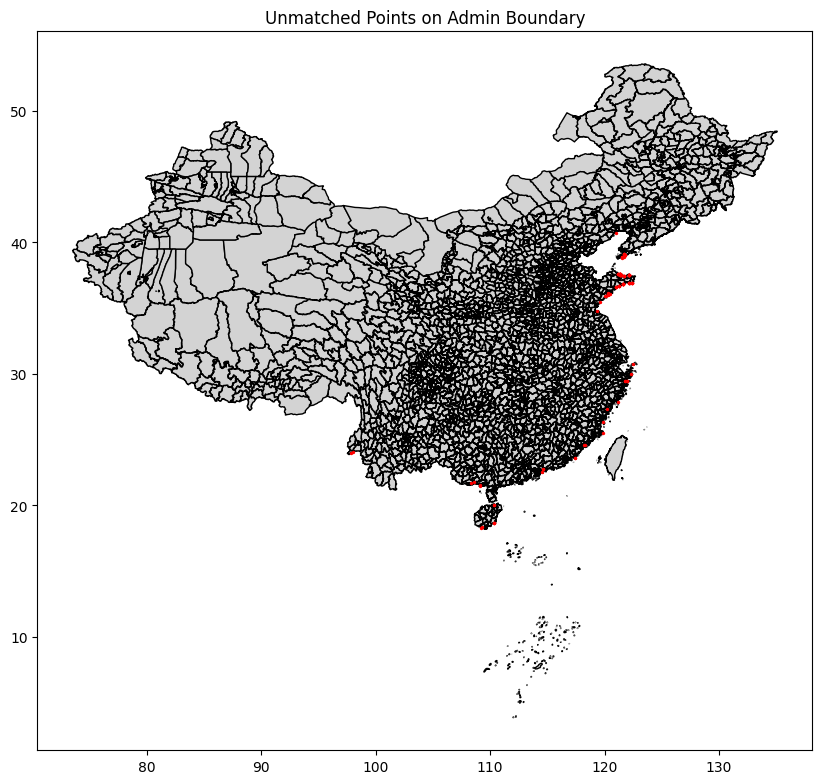

In [69]:
import matplotlib.pyplot as plt


gdf_unmatched = gpd.GeoDataFrame(
    df_unmatched,
    geometry=gpd.points_from_xy(df_unmatched["lng84"], df_unmatched["lat84"]),
    crs="EPSG:4326"
)

base = gdf_admin.plot(color='lightgrey', edgecolor='black', figsize=(10, 10))
gdf_unmatched.plot(ax=base, color='red', markersize=2)
plt.title("Unmatched Points on Admin Boundary")
plt.show()


### Check the number of city

Number of unique province-city combinations: 339

In [70]:

df_matched_final["city"] = df_matched_final["city"].replace(["NULL", "null", "", "NaN", "nan"], pd.NA)

df_matched_final["prov_city"] = df_matched_final.apply(
    lambda row: f"{row['province']}-{row['city']}" if pd.notna(row["city"]) else f"{row['province']}-{row['province']}",
    axis=1
)

unique_cities = df_matched_final["prov_city"].nunique()
print(f" Number of unique province-city combinations: {unique_cities}")


prov_city_list = df_matched_final["prov_city"].drop_duplicates().sort_values().tolist()
print(prov_city_list)



/var/folders/4g/6_8lhyp147394q93651p5kyw0000gn/T/ipykernel_63305/753897206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matched_final["city"] = df_matched_final["city"].replace(["NULL", "null", "", "NaN", "nan"], pd.NA)


 Number of unique province-city combinations: 339
['Anhui-Anqing', 'Anhui-Bengbu', 'Anhui-Bozhou', 'Anhui-Chizhou', 'Anhui-Chuzhou', 'Anhui-Fuyang', 'Anhui-Hefei', 'Anhui-Huaibei', 'Anhui-Huainan', 'Anhui-Huangshan', 'Anhui-Liuan', 'Anhui-Maanshan', 'Anhui-Suzhou', 'Anhui-Tongling', 'Anhui-Wuhu', 'Anhui-Xuancheng', 'Beijing-Beijing', 'Chongqing-Chongqing', 'Fujian-Fuzhou', 'Fujian-Longyan', 'Fujian-Nanping', 'Fujian-Ningde', 'Fujian-Putian', 'Fujian-Quanzhou', 'Fujian-Sanming', 'Fujian-Xiamen', 'Fujian-Zhangzhou', 'Gansu-Baiyin', 'Gansu-Dingxi', 'Gansu-Gannanzangzu', 'Gansu-Jiayuguan', 'Gansu-Jinchang', 'Gansu-Jiuquan', 'Gansu-Lanzhou', 'Gansu-Linxiahuizu', 'Gansu-Longnan', 'Gansu-Pingliang', 'Gansu-Qingyang', 'Gansu-Tianshui', 'Gansu-Wuwei', 'Gansu-Zhangye', 'Guangdong-Chaozhou', 'Guangdong-Dongguan', 'Guangdong-Foshan', 'Guangdong-Guangzhou', 'Guangdong-Heyuan', 'Guangdong-Huizhou', 'Guangdong-Jiangmen', 'Guangdong-Jieyang', 'Guangdong-Maoming', 'Guangdong-Meizhou', 'Guangdong-Qingyu

/var/folders/4g/6_8lhyp147394q93651p5kyw0000gn/T/ipykernel_63305/753897206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_matched_final["prov_city"] = df_matched_final.apply(


In [71]:
# Save the matched and unmatched data to CSV files
df_matched_final.to_csv(output_csv_path, index=False)
df_unmatched.to_csv(unmatched_csv_path, index=False)
print(f" matched data saved to: {output_csv_path}")
print(f" unmatched data saved to: {unmatched_csv_path}")

 matched data saved to: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price.csv
 unmatched data saved to: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price_unmatched.csv



## Retaining Data Points Within Built-Up Areas

Using the 2020 built-up area map, we retain only the residential community points located within built-up areas, treating them as urban housing price points.

### Merging Built-Up Area Shapefiles

The built-up area data is stored by province, with each provincial folder containing shapefiles for cities with populations over 300,000. To facilitate filtering, I first merged all these files into a single shapefile.


In [150]:
import geopandas as gpd
import pandas as pd
import os
from tqdm import tqdm  

root_folder = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_BuiltUp_300kCities_2020"
output_folder = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020"
output_shp_path = os.path.join(output_folder, "China_BuiltUp_300kCities_2020.shp")

os.makedirs(output_folder, exist_ok=True)

gdf_list = []
error_files = []

all_target_files = []
for province in os.listdir(root_folder):
    province_path = os.path.join(root_folder, province)
    if os.path.isdir(province_path):
        for filename in os.listdir(province_path):
            if filename.endswith("2020_new_Urb.shp"):
                all_target_files.append((province, filename))

for province, filename in tqdm(all_target_files, desc="Processing cities"):
    province_path = os.path.join(root_folder, province)
    full_path = os.path.join(province_path, filename)
    try:
        gdf = gpd.read_file(full_path)
        gdf = gdf.to_crs("EPSG:4326")
        gdf["province"] = province
        gdf["city"] = filename.replace("2020_new_Urb.shp", "")
        gdf_list.append(gdf)
    except Exception as e:
        error_files.append((province, filename, str(e)))


if gdf_list:
    gdf_all = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)
    gdf_all.to_file(output_shp_path)
    print(f"\n successfully saved to {output_shp_path}")
else:
    print("\n No shapefiles found in the specified directory.")


if error_files:
    print("\n the following files failed to read:")
    for prov, fname, err in error_files:
        print(f"- {prov}/{fname} :{err}")
else:
    print("\n all files read successfully.")


Processing cities:  83%|████████▎ | 354/429 [00:10<00:01, 40.42it/s]/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_BuiltUp_300kCities_2020/Anhui/hefei2020_new_Urb.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
Processing cities:  84%|████████▍ | 361/429 [00:10<00:01, 45.48it/s]/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Raw/China_BuiltUp_300kCities_2020/Xinjiang/wulumuqi2020_new_Urb.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(
Processing cities: 100%|██████████| 429/429 [00:11<00:00, 37.46it/s]
/opt/anaconda3/envs/midway-de


 successfully saved to /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020/China_BuiltUp_300kCities_2020.shp

 all files read successfully.


/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 509121090.60600001 of field AREA_GEO of feature 24035 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 424834453.93909693 of field AREA_GEO of feature 24196 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 169659011.01253 of field AREA_GEO of feature 24289 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(
/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:723: RuntimeWarning: Value 251964951.64084721 of field AREA_GEO of feature 24367 not successfully written. Possibly due to too larger number with respect


### Matching Residential Communities Located Within Built-Up Areas

After merging the built-up area shapefiles, we perform a spatial join between the previously filtered `house_price.csv` and the merged shapefile `China_BuiltUp_300kCities_2020.shp`. This allows us to identify and retain only those housing price points that fall within urban (built-up) areas. The matched urban points are saved in `builtup_hp.csv` and serve as the final dataset for urban housing prices.

It is worth noting that the built-up area dataset only includes cities with populations over 300,000. As a result, some residential communities are excluded from the final sample. The matching results are as follows:

* **Successfully matched data points:** 579,328
* **Total data points:** 899,161
* **Match rate:** 64.43%



In [154]:

house_price_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/house_price.csv"
builtup_shp_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020/China_BuiltUp_300kCities_2020.shp"
output_csv_path = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/builtup_hp.csv"


df_hp = pd.read_csv(house_price_path)
gdf_hp = gpd.GeoDataFrame(
    df_hp,
    geometry=gpd.points_from_xy(df_hp["lng84"], df_hp["lat84"]),
    crs="EPSG:4326"
)


gdf_builtup = gpd.read_file(builtup_shp_path)
if gdf_hp.crs != gdf_builtup.crs:
    gdf_builtup = gdf_builtup.to_crs(gdf_hp.crs)

gdf_hp_builtup = gpd.sjoin(gdf_hp, gdf_builtup, how="inner", predicate="intersects")


matched_count = len(gdf_hp_builtup)
total_count = len(gdf_hp)
print(f"successfully matched data points: {matched_count}")
print(f"total data points: {total_count}")
print(f"matched rate:{100 * matched_count / total_count:.2f}%")




/opt/anaconda3/envs/midway-debug/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/China_BuiltUp_300kCities_2020/China_BuiltUp_300kCities_2020.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


successfully matched data points: 579328
total data points: 899161
matched rate:64.43%


In [168]:
print(gdf_builtup["province"].unique())
print(len(gdf_builtup["province"].unique()))

['Heilongjiang' 'Neimenggu' 'Beijing' 'Qinghai' 'Shanghai' 'Shandong'
 'Henan' 'Hainan' 'Shaanxi' 'Fujian' 'Jiangxi' 'Yunnan' 'Hubei' 'Macao'
 'Tianjin' 'Guangxi' 'Liaoning' 'Sichuan' 'Taiwan' 'Guizhou' 'Ningxia'
 'Chongqing' 'Shanxi' 'Guangdong' 'Hunan' 'HongKong' 'Jiangsu' 'Anhui'
 'Xinjiang' 'Jilin' 'Hebei' 'Zhejiang' 'Gansu']
33


In [75]:
gdf_hp_builtup.columns

Index(['id', '名称', '城市', '区县', '乡镇', '建筑年份', '类型', '地址', 'lng84', 'lat84',
       '供热', '容积率', '面积', '总户数', '类型.1', '供水', '得分', '月份', '环比', '价格',
       'province_left', 'city_left', 'county', 'prov_city', 'geometry',
       'index_right', 'gridcode', 'AREA_GEO', 'province_right', 'city_right'],
      dtype='object')

In [155]:

gdf_hp_builtup = gdf_hp_builtup.rename(columns={
    "province_left": "province",
    "city_left": "city"
})

cols_to_keep = df_hp.columns.tolist()
gdf_result = gdf_hp_builtup[cols_to_keep]


In [156]:
unmatched = gdf_hp[~gdf_hp["id"].isin(gdf_hp_builtup["id"])]
unmatched = unmatched.drop(columns=["geometry"])
unmatched.to_csv("/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/builtup_hp_unmatched.csv", index=False)

print(f"unmatched data points: {len(unmatched)}")

unmatched data points: 320207


In [114]:
gdf_result.columns

Index(['id', '名称', '城市', '区县', '乡镇', '建筑年份', '类型', '地址', 'lng84', 'lat84',
       '供热', '容积率', '面积', '总户数', '类型.1', '供水', '得分', '月份', '环比', '价格',
       'province', 'city', 'county', 'prov_city'],
      dtype='object')

In [158]:
gdf_result.to_csv(output_csv_path, index=False)
print(f" successfully saved to {output_csv_path}")

 successfully saved to /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/builtup_hp.csv




### Checking the Number of Matched Residential Communities by City

To avoid confusion caused by cities with the same name, we distinguish them using a combined `prov_city` identifier. In total, the dataset includes **282 cities**, among which one entry is labeled as `"NULL-NULL"`. After dropping this invalid entry, we are left with **281 valid cities**.

Across these cities:

* The **minimum** number of housing price samples per city is **120**
* The **average** is **880**
* The **75th percentile** is **2,030**
* The **maximum** reaches **22,384** (in **Shanghai**)

Overall, the sample size is sufficiently large for analysis in most cities.


In [159]:
gdf_result.head(3)

,id,名称,城市,区县,乡镇,建筑年份,类型,地址,lng84,lat84,供热,容积率,面积,总户数,类型.1,供水,得分,月份,环比,价格,province,city,county,prov_city
333,7531,中医院家属楼,阿克苏,阿克苏市,阿克苏城区,NaN,多层,南昌路,80.257811,41.176637,NaN,NaN,NaN,0,公寓住宅,民用,7.6,12,0.0,4603.0,Xinjiang,Akesu,Akesu,Xinjiang-Akesu
334,7777,保险公司家属院,阿克苏,阿克苏市,阿克苏城区,NaN,小高层,迎宾路,80.284069,41.176729,NaN,NaN,NaN,0,公寓住宅,民用,7.4,12,0.0,4158.0,Xinjiang,Akesu,Akesu,Xinjiang-Akesu
335,7778,新桃小区,阿克苏,阿克苏市,阿克苏城区,NaN,多层,小南街10号,80.261010,41.164120,NaN,NaN,NaN,0,公寓住宅,民用,7.9,12,0.0,3727.0,Xinjiang,Akesu,Akesu,Xinjiang-Akesu


In [160]:
gdf_result.shape

(579328, 24)

In [161]:
gdf_result['prov_city'].nunique()

282

In [162]:

city_counts = gdf_result.groupby("prov_city").size().reset_index(name="count")

city_counts_inc = city_counts.sort_values(by="count", ascending=True)

city_counts_inc.head()


,prov_city,count
189,NULL-NULL,1
99,Heilongjiang-Yichun,120
96,Heilongjiang-Qitaihe,125
229,Shanxi-Tongchuan,125
28,Gansu-Jiayuguan,127


In [163]:
city_counts_dec = city_counts.sort_values(by="count", ascending=False)
city_counts_dec.head()

,prov_city,count
217,Shanghai-Shanghai,22384
239,Sichuan-Chengdu,17881
214,Shandong-Yantai,15940
38,Guangdong-Guangzhou,13431
16,Beijing-Beijing,12562


In [165]:
gdf_result= gdf_result[gdf_result["prov_city"]!= "NULL-NULL"]

In [166]:
city_counts = gdf_result.groupby("prov_city").size().reset_index(name="count")

city_counts_inc = city_counts.sort_values(by="count", ascending=True)

city_counts_inc.head()

,prov_city,count
99,Heilongjiang-Yichun,120
228,Shanxi-Tongchuan,125
96,Heilongjiang-Qitaihe,125
28,Gansu-Jiayuguan,127
260,Xinjiang-Kelamayi,131


In [170]:
city_counts.describe()

,count
count,281.000000
mean,2061.661922
std,2966.955348
min,120.000000
25%,490.000000
50%,880.000000
75%,2030.000000
max,22384.000000


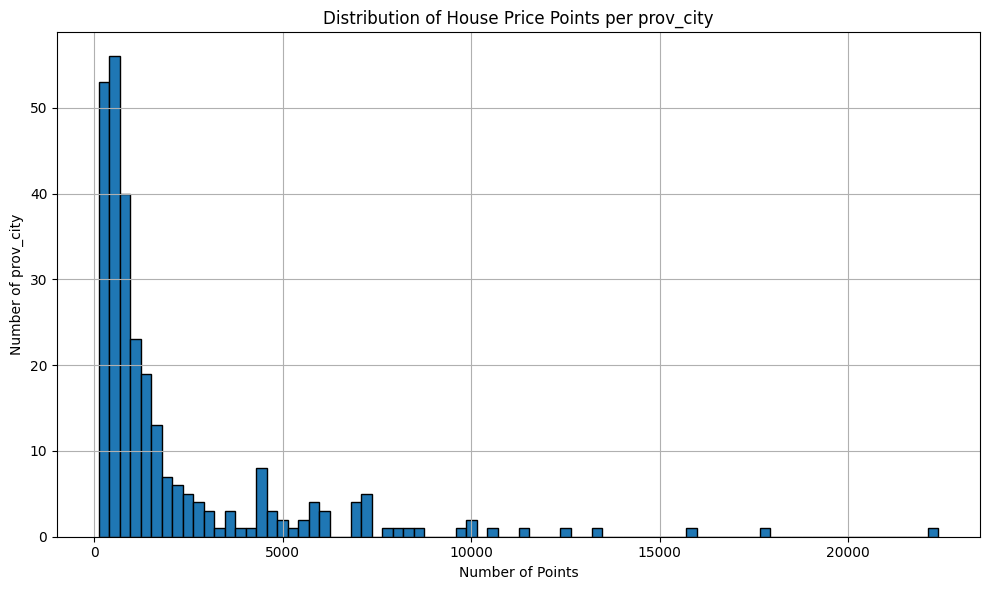

the first bin: 120.0-398.3


In [167]:

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(city_counts["count"], bins=80, edgecolor="black")
plt.title("Distribution of House Price Points per prov_city")
plt.xlabel("Number of Points")
plt.ylabel("Number of prov_city")
plt.grid(True)
plt.tight_layout()
plt.show()


print(f"the first bin: {bins[0]}-{bins[1]}")



## Saving Data by City

We group the data in `builtup_hp.csv` by the `prov_city` identifier and save each group as a separate CSV file named `prov_city_hp.csv`. These files are stored in the `City_hp` folder. This structure facilitates parallel processing in subsequent tasks, including land rent estimation, land rent curve fitting, and welfare loss calculations related to policy evaluation.


In [174]:

input_csv = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/builtup_hp.csv"
output_folder = "/Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/City_hp"

os.makedirs(output_folder, exist_ok=True)

df = pd.read_csv(input_csv)
df = df[df["prov_city"] != "NULL-NULL"]

def safe_filename(name):
    return name.replace("/", "_").replace(" ", "").replace("\\", "_")


for prov_city, group in df.groupby("prov_city"):
    filename = f"{safe_filename(prov_city)}_hp.csv"
    output_path = os.path.join(output_folder, filename)
    group.to_csv(output_path, index=False)

print(f" {df['prov_city'].nunique()} files saved to {output_folder}")


 281 files saved to /Users/yxy/UChi/Spring2025/MACS30123/Final_project/Data/Cleaned/City_hp
